In [1]:
import numpy as np
import terra

from meerkat.contrib.eeg import build_stanford_eeg_dp

from domino.emb.eeg import generate_words_dp, embed_words, embed_eeg
from domino.evaluate import run_sdms, score_sdm_explanations, score_sdms, run_sdm
from domino.sdm import MixtureModelSDM, SpotlightSDM
from domino.slices import collect_settings
from domino.train import score_settings, synthetic_score_settings, train_settings
from domino.utils import split_dp, balance_dp

import meerkat as mk
import seaborn as sns
import matplotlib.pyplot as plt


/home/ksaab/Documents/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [2]:
setting_dp = collect_settings.out(load=True)
setting_dp

,alpha (NumpyArrayColumn),build_setting_kwargs (ListColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),slice_names (ListColumn),target_name (PandasSeriesColumn),index (PandasSeriesColumn),setting_id (PandasSeriesColumn)
0,0.010000,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.01, 'n': 8000}",eeg,rare,['age<1'],sz,0,be0e2cb7-7e97-439e-8648-f46be5a40c84
1,0.015445,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.01544452104946379, 'n': 8000}",eeg,rare,['age<1'],sz,1,48e30aa8-acd4-4c36-b08d-3bf667d41f17
2,0.023853,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.023853323044733008, 'n': 8000}",eeg,rare,['age<1'],sz,2,7e31f346-78d8-43a0-bfda-fa28ad704421
3,0.036840,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.03684031498640387, 'n': 8000}",eeg,rare,['age<1'],sz,3,828a64f9-95b9-4449-81a8-79f7363d5456
4,0.056898,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.05689810202763908, 'n': 8000}",eeg,rare,['age<1'],sz,4,0d08617a-dddc-4a43-9bee-f361621cd896
5,0.087876,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.08787639344404101, 'n': 8000}",eeg,rare,['age<1'],sz,5,98ecaee6-e934-47e2-8a7f-2bce26348bb4
6,0.135721,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.13572088082974532, 'n': 8000}",eeg,rare,['age<1'],sz,6,15dd2ba8-7ef1-4894-939e-bf1fa7b74103
7,0.209614,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.20961440008267682, 'n': 8000}",eeg,rare,['age<1'],sz,7,e2b8a11d-f472-4f80-8faf-850fef998e5d
8,0.323739,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.32373940143476265, 'n': 8000}",eeg,rare,['age<1'],sz,8,3fec63ea-c422-4a57-ab2e-47a37b2ab412
9,0.500000,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.5, 'n': 8000}",eeg,rare,['age<1'],sz,9,4d3effc7-bb7c-45d7-bfea-9d68120e9570


In [3]:
run_sdms_dp = run_sdms.out(load=True)
run_sdms_dp.head()

,score_model_run_id (NumpyArrayColumn),setting_id (PandasSeriesColumn),build_setting_run_id (NumpyArrayColumn),score_settings_run_id (NumpyArrayColumn),synthetic_preds (NumpyArrayColumn),index (PandasSeriesColumn),target_name (PandasSeriesColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),build_setting_kwargs (ListColumn),slice_names (ListColumn),alpha (NumpyArrayColumn),run_sdm_run_id (PandasSeriesColumn),emb_group (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),sdm_config/learning_rate (PandasSeriesColumn),sdm_config/n_slices (PandasSeriesColumn),sdm_config/emb (PandasSeriesColumn),sdm_config/xmodal_emb (PandasSeriesColumn),config/sdm (PandasSeriesColumn),config/slice (PandasSeriesColumn),logdir (PandasSeriesColumn),sdm_config/weight_y_log_likelihood (PandasSeriesColumn),sdm_config/n_clusters (PandasSeriesColumn),sdm_class (PandasSeriesColumn)
0,1910,962bac11-bc53-4cc9-9bdd-6df5339ae33f,1910,1909,True,0,sz,eeg,correlation,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}","['sz=0_age>1', 'sz=1_age<1']",0.0,1932,eeg,49.461566,False,NaN,NaN,1,3497ff2e4000491faba38c5fb1f00a25,2021-09-29_16-45-57,1632959157,49.461566,24595,gemini1,171.65.28.88,49.461566,0,1,405bf_00000,0.001,10,emb,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['eeg', 'emb'], 'learning_rate': 0.001, 'n_clusters': None, 'n_slices': 10, 'weight_y_log_likelihood': None, 'xmodal_emb': 'emb'}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'n': 8000, 'slice_frac': None}, 'build_setting_run_id': 1910, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 1910, 'score_settings_run_id': 1909, 'setting_id': '962bac11-bc53-4cc9-9bdd-6df5339ae33f', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'True', 'target_name': 'sz'}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/1930/_evaluate_2021-09-29_16-44-56/_evaluate_405bf_00000_0_sdm={'sdm_class': , 'sdm_config': {'learning_rate': 0.001, 'n_s_2021-09-29_16-44-56",NaN,NaN,domino.sdm.spotlight.SpotlightSDM
1,1910,962bac11-bc53-4cc9-9bdd-6df5339ae33f,1910,1909,True,1,sz,eeg,correlation,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}","['sz=0_age>1', 'sz=1_age<1']",0.0,1968,multimodal,51.965613,False,NaN,NaN,1,12b0a06f04394c279b77ccfe2642625c,2021-09-29_16-47-01,1632959221,51.965613,27889,gemini1,171.65.28.88,51.965613,0,1,405bf_00001,0.001,10,emb,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['multimodal', 'emb'], 'learning_rate': 0.001, 'n_clusters': None, 'n_slices': 10, 'weight_y_log_likelihood': None, 'xmodal_emb': 'emb'}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'n': 8000, 'slice_frac': None}, 'build_setting_run_id': 1910, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 1910, 'score_settings_run_id': 1909, 'setting_id': '962bac11-bc53-4cc9-9bdd-6df5339ae33f', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'True', 'target_name': 'sz'}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/1930/_evaluate_2021-09-29_16-44-56/_evaluate_405bf_00001_1_sdm={'sdm_class': , 'sdm_config': {'learning_rate': 0.001, 'n_s_2021-09-29_16-44-56",NaN,NaN,domino.sdm.spotlight.SpotlightSDM
2,1910,962bac11-bc53-4cc9-9bdd-6df5339ae33f,1910,1909,T

In [5]:
score_dp = mk.DataPanel.from_pandas(score_sdms.out(load=True))
score_dp

,pred_slice_idx (PandasSeriesColumn),slice_idx (PandasSeriesColumn),auroc (PandasSeriesColumn),precision_at_10 (PandasSeriesColumn),precision_at_25 (PandasSeriesColumn),precision_at_100 (PandasSeriesColumn),recall_at_50 (PandasSeriesColumn),recall_at_100 (PandasSeriesColumn),recall_at_200 (PandasSeriesColumn),recall (PandasSeriesColumn),precision (PandasSeriesColumn),target_name (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),slice_name (PandasSeriesColumn),index (PandasSeriesColumn)
0,0.0,0.0,0.690370,0.4,0.40,0.43,0.120192,0.206731,0.365385,0.254808,0.206226,sz,1932.0,sz=0_age>1,0
1,1.0,0.0,0.690776,0.4,0.40,0.43,0.120192,0.206731,0.365385,0.019231,1.000000,sz,1932.0,sz=0_age>1,1
2,2.0,0.0,0.690969,0.4,0.40,0.43,0.120192,0.206731,0.365385,0.009615,0.400000,sz,1932.0,sz=0_age>1,2
3,3.0,0.0,0.691359,0.4,0.40,0.43,0.120192,0.206731,0.365385,0.024038,0.263158,sz,1932.0,sz=0_age>1,3
4,4.0,0.0,0.691362,0.4,0.40,0.43,0.120192,0.206731,0.365385,0.673077,0.162413,sz,1932.0,sz=0_age>1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,5.0,0.0,0.500000,0.3,0.72,0.75,0.000000,0.000000,0.000000,0.000000,0.000000,sz,2076.0,age<1,2395
2396,6.0,0.0,0.500000,0.3,0.72,0.75,0.000000,0.000000,0.000000,0.000000,0.000000,sz,2076.0,age<1,2396
2397,7.0,0.0,0.500000,0.3,0.72,0.75,0.000000,0.000000,0.000000,0.000000,0.000000,sz,2076.0,age<1,2397
2398,8.0,0.0,0.500000,0.3,0.72,0.75,0.000000,0.000000,0.000000,0.000000,0.000000,sz,2076.0,age<1,2398


In [14]:
results_dp = mk.merge(
    score_dp,
    run_sdms_dp["sdm_class", "config/sdm", "alpha", "run_sdm_run_id", "build_setting_kwargs", "slice_category"], # include any other columns here you'd like to analyze
    on="run_sdm_run_id"
)
emb_col = results_dp["config/sdm"].map(lambda x: x["sdm_config"]["emb"][0])
results_dp["emb_type"] = emb_col

corr_thresh_col = results_dp["build_setting_kwargs"].map(lambda x: x["correlate_threshold"] if "correlate_threshold" in x else x["attribute_thresh"])
results_dp["corr_thresh"] = corr_thresh_col


results_df = results_dp.to_pandas()
results_df

,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,...,target_name,slice_name,index,sdm_class,config/sdm,alpha,build_setting_kwargs,slice_category,emb_type,corr_thresh
0,1932,0,0,0.690370,0.4,0.40,0.43,0.120192,0.206731,0.365385,...,sz,sz=0_age>1,0,domino.sdm.spotlight.SpotlightSDM,{'sdm_class': '<class 'domino.sdm.spotlight.Sp...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
1,1932,1,0,0.690776,0.4,0.40,0.43,0.120192,0.206731,0.365385,...,sz,sz=0_age>1,1,domino.sdm.spotlight.SpotlightSDM,{'sdm_class': '<class 'domino.sdm.spotlight.Sp...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
2,1932,2,0,0.690969,0.4,0.40,0.43,0.120192,0.206731,0.365385,...,sz,sz=0_age>1,2,domino.sdm.spotlight.SpotlightSDM,{'sdm_class': '<class 'domino.sdm.spotlight.Sp...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
3,1932,3,0,0.691359,0.4,0.40,0.43,0.120192,0.206731,0.365385,...,sz,sz=0_age>1,3,domino.sdm.spotlight.SpotlightSDM,{'sdm_class': '<class 'domino.sdm.spotlight.Sp...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
4,1932,4,0,0.691362,0.4,0.40,0.43,0.120192,0.206731,0.365385,...,sz,sz=0_age>1,4,domino.sdm.spotlight.SpotlightSDM,{'sdm_class': '<class 'domino.sdm.spotlight.Sp...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",correlation,eeg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2076,5,0,0.500000,0.3,0.72,0.75,0.000000,0.000000,0.000000,...,sz,age<1,2395,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'attribute': 'age', 'attribute_thresh': 1, 's...",rare,multimodal,1
2396,2076,6,0,0.500000,0.3,0.72,0.75,0.000000,0.000000,0.000000,...,sz,age<1,2396,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'attribute': 'age', 'attribute_thresh': 1, 's...",rare,multimodal,1
2397,2076,7,0,0.500000,0.3,0.72,0.75,0.000000,0.000000,0.000000,...,sz,age<1,2397,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'attribute': 'age', 'attribute_thresh': 1, 's...",rare,multimodal,1
2398,2076,8,0,0.500000,0.3,0.72,0.75,0.000000,0.000000,0.000000,...,sz,age<1,2398,domino.sdm.confusion.ConfusionSDM,{'sdm_class': '<class 'domino.sdm.confusion.Co...,0.5,"{'attribute': 'age', 'attribute_thresh': 1, 's...",rare,multimodal,1


<ipython-input-16-8a4221081cec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["success"] = grouped_df["precision_at_10"] > 0.8


240


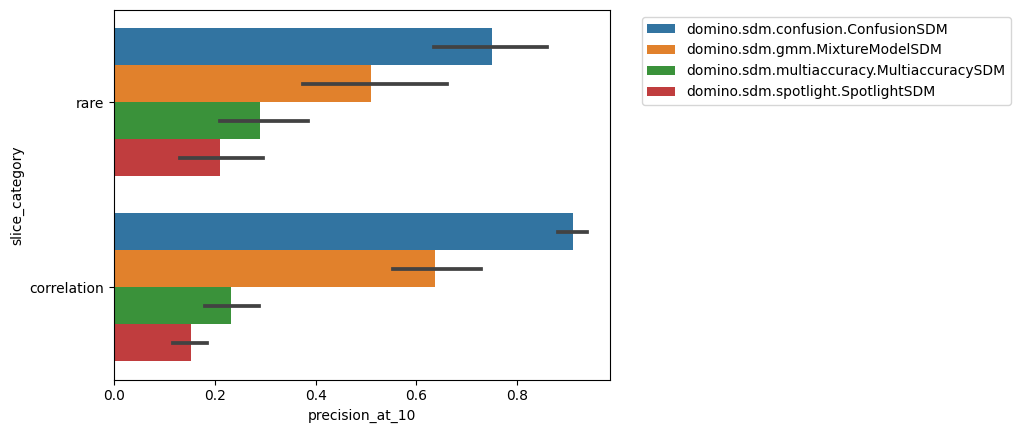

In [16]:
metric = "precision_at_10"
grouped_df = results_df.iloc[results_df.reset_index().groupby(["sdm_class", "slice_name", "slice_idx","emb_type", "alpha", "corr_thresh", "slice_category"])[metric].idxmax().astype(int)]

grouped_df["success"] = grouped_df["precision_at_10"] > 0.8

print(len(grouped_df))
#ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
#ax = sns.violinplot(data=grouped_df,x=metric,y="emb_type")
ax = sns.barplot(data=grouped_df,x=metric,y="slice_category",hue="sdm_class")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


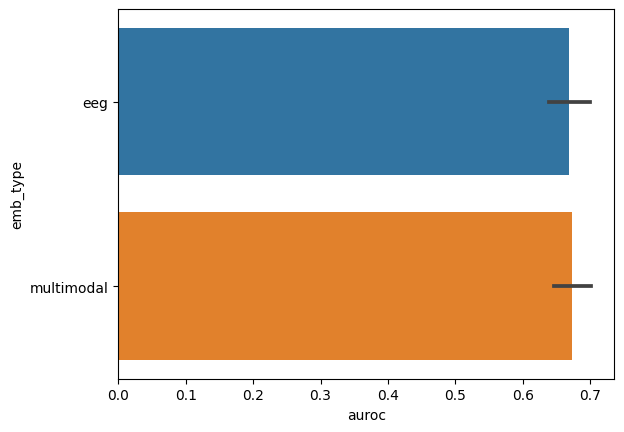

In [10]:
metric = "auroc"
grouped_df = results_df.iloc[results_df.reset_index().groupby(["sdm_class", "slice_name", "slice_idx","emb_type","alpha","corr_thresh"])[metric].idxmax().astype(int)]


#ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
ax = sns.barplot(data=grouped_df,x=metric,y="emb_type")
plt.show()

In [52]:
from domino.slices.abstract import build_setting

synthetic_preds_dp = synthetic_score_settings.out(load=True)
print(len(synthetic_preds_dp))
for index in range(len(synthetic_preds_dp)):
    
    synth_dp = build_setting.out(synthetic_preds_dp[index]["build_setting_run_id"],load=True)

    preds = np.array(synth_dp.lz["probs"][:,1] > 0.5)
    targets = np.array(synth_dp.lz["target"])
    in_slice = synth_dp.lz["slices"][:,0]

    #print((preds != targets).mean())
    #print((preds[in_slice]!= targets[in_slice]).mean())
    print(in_slice[preds != targets].mean())

#synth_dp.head()

20
0.7291487532244196
0.7488584474885844
0.753514526710403
0.7651920272241128
0.779839518555667
0.7969370391378332
0.8298525798525799
0.8394062078272605
0.8810020876826722
0.9019896831245394
0.9530956848030019
0.935483870967742
0.9184043517679057
0.8625336927223719
0.7963576158940397
0.7093397745571659
0.6166912850812407
0.5042735042735043
0.6487437185929649
0.8001589193484306


In [32]:
in_slice.shape

(6068,)

In [ ]:
# grouped_df["success"] = np.logical_and(grouped_df["auroc"] > 0.7, grouped_df["precision_at_10"] > 0.4)

# #ax = sns.pointplot(data=grouped_df,x="alpha",y="success", hue="emb_type", dodge=True, join=False)
# ax = sns.barplot(data=grouped_df,x="success",y="emb_type")

# plt.show()

# Explanations

In [ ]:
words_dp = embed_words.out(load=True)

# get multimodal sdm run ids
slice_id = 0
alpha = 0.8

specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==slice_id][grouped_df["alpha"]==alpha]
specific_run

In [ ]:
pred_slice_idx = specific_run["pred_slice_idx"].values[0]
_, expl_dp = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][:10]

In [ ]:
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][10:20]